In [1]:
import math
import json
import mdptoolbox
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class MDPToolBoxWrapper:
    """Convert the plain object description of the mdp into gamma and T and R matrices"""
    def __init__(self, descr):
        self.descr = descr
        self.gamma = descr["gamma"]
        self.nS = len(descr["states"])
        self.nA = len(descr["states"][0]["actions"])
        self.transitions = np.zeros((self.nA, self.nS, self.nS))
        self.rewards = np.zeros((self.nA, self.nS, self.nS))
        state_indexes = {state["id"]: i for i, state in enumerate(descr["states"])}
        for state in descr["states"]:
            assert len(state["actions"]) == self.nA, "All states must have same number of possible actions"
            for i, action in enumerate(state["actions"]):
                for transition in action["transitions"]:
                    state_index = state_indexes[state["id"]]
                    new_state_index = state_indexes[transition["to"]]
                    self.transitions[i, state_index, new_state_index] = transition["probability"]
                    self.rewards[i, state_index, new_state_index] = transition["reward"]
                    
def create_MDP(P, gamma):
    
    mdp = {}
    mdp["gamma"] = gamma
    mdp["states"] = []
        
    for s in P:
        mdp["states"].append({})
        mdp["states"][-1]["id"] = s
        mdp["states"][-1]["actions"] = []
        
        for a in P[s]:
            mdp["states"][-1]["actions"].append({})
            mdp["states"][-1]["actions"][-1]["id"] = a
            mdp["states"][-1]["actions"][-1]["transitions"] = []
            
            for i, (prob, s_prime, reward, done) in enumerate(P[s][a]):
                
                mdp["states"][-1]["actions"][-1]["transitions"].append({})
                mdp["states"][-1]["actions"][-1]["transitions"][-1]["id"] = i
                mdp["states"][-1]["actions"][-1]["transitions"][-1]["probability"] = prob
                mdp["states"][-1]["actions"][-1]["transitions"][-1]["reward"] = reward
                mdp["states"][-1]["actions"][-1]["transitions"][-1]["to"] = s_prime
    return mdp

def create_json_from_P(P, name, gamma=0.99, write=True):
    
    mdp = create_MDP(P, gamma)
    js = json.dumps(mdp, ensure_ascii=False, sort_keys=True, indent=2)
    if write:
        with open("./" + name + ".json", "w") as text_file:
            text_file.write(js)
    return mdp

In [22]:
book_grid = [[' ',' ',' ',+100],
            [' ','#',' ',-100],
            ['@',' ',' ',' ']]

# book_grid = [[' ',' ',' ',+100],
#             [' ','#',' ',-100],
#             ['@',' ',' ',' ']]

def run_policy_iteration_from_T(T, gamma):
    mdp = MDPToolBoxWrapper(create_MDP(T, gamma))
    pi = mdptoolbox.mdp.PolicyIteration(mdp.transitions, mdp.rewards, mdp.gamma)
    pi.run()
    return pi

def run_policy_iteration(mdp):
    pi = mdptoolbox.mdp.PolicyIteration(mdp.transitions, mdp.rewards, mdp.gamma)
    pi.run()
    return pi
    
class GridWorld(object):
    """
    This is a nice approximation for all the complexity of the entire universe 
        –Charles Isbell
    """
    MARKER_WALL = '#'
    MARKER_CURR_STATE = '@'
    MARKER_FREE_SPACE = ' '
    
    def __init__(self, grid, living_reward=-0.01, gamma=0.99, action_noise_dist=[0.1, 0.8, 0.1]):
        
        """
        Returns a grid world with input specifications. 
        
        Grid spec: '#' walls, '<int>' terminal state, 'S' initial position, ' ' free space
        """
        
        assert(len(grid) != 0 and len(grid[0]) != 0)
        
        self.grid = grid.copy()
        self.width = len(grid[0])
        self.height = len(grid)
        self.living_reward = living_reward
        self.action_noise_dist = action_noise_dist
        self.actions_name = ["North", "East", "South", "West"]
        self.actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.curr_state, self.states = self._compute_states(grid)
        self.nA = len(self.actions)
        self.nS = len(self.states)
        self.states_to_idx = dict(zip(self.states, range(self.nS)))
        self.T = self.get_T()
        self.gamma = gamma
        self.mdp = MDPToolBoxWrapper(create_MDP(self.T, self.gamma))
        self.policy_iteration_results = run_policy_iteration(self.mdp)
    
    def _compute_states(self, grid, feature_type='2d_loc'):
        """
        Returns: Computes number of states in the grid world.
        Input: 
            grid: grid description as python 2d array of strings (Ref: book_grid)
        """
        states = []
        for row in range(self.height): #[::-1]: # all rows, reverse order so that 0th state is (0,0)
            for col in range(self.width): # all cols
                
                # State feature is simply (row#, col#)
                state_feat1, state_feat2 = row, col
                # Walls act like obstacles, and bumping into them won't change state (for now)
                if grid[row][col] != self.MARKER_WALL:
                    if grid[row][col] == self.MARKER_CURR_STATE:
                        if feature_type == '2d_loc':
                            init_state = (state_feat1, state_feat2)
                        else:
                            raise ValueError("Not Supported feature_type={}!".format(feature_type))
                    states.append((state_feat1, state_feat2))
        return init_state, states
    
    def _is_terminal(self, s_idx):
        """
        Returns: boolean representing whether a state represented by its index is a terminal
            As per current model, this will be True for grid cells with integer reward value
        """
        r, c = self.states[s_idx]
        return isinstance(self.grid[r][c], int) or isinstance(self.grid[r][c], float)
    
    def reward(self, s_idx):
        r, c = self.states[s_idx]
        if isinstance(self.grid[r][c], int) or isinstance(self.grid[r][c], float):
            return float(self.grid[r][c])
        else:
            return self.living_reward
        
    def stochastic_action(self, a_idx):
        return np.random.choice([a_idx-1, a_idx, (a_idx+1)%self.nA], p=self.action_noise_dist)
    
    def next_states_with_probs(self, s_idx, a_idx):
        """
        Returns: Returns (next states, probabilities next states) for given state and stochastic action
        """
        assert(len(self.action_noise_dist) == 3)
        
        state_primes_to_probs = {}
        r, c = self.states[s_idx]
        for j, noisy_a_idx in enumerate([a_idx-1, a_idx, (a_idx+1)%self.nA]): # hard coded for len(self.action_noise_dist) == 3
            
            dr, dc = self.actions[noisy_a_idx]
            p = self.action_noise_dist[j]
            new_r, new_c = r+dr, c+dc
            if new_r < 0 or new_r >= self.height \
                or new_c < 0 or new_c >= self.width \
                or self.grid[new_r][new_c] == self.MARKER_WALL:
                    new_r, new_c = r, c
                    
            if self.states_to_idx[(new_r, new_c)] in state_primes_to_probs:
                state_primes_to_probs[self.states_to_idx[(new_r, new_c)]] += p
            else:
                state_primes_to_probs[self.states_to_idx[(new_r, new_c)]] = p
            
        return state_primes_to_probs.items()
    
    def get_T(self):
        """
        Returns: MDP Transitions T{s}{a} = (p, s_prime, r, done) for all s, a, s_prime
        """
        mdp = {}
        for s_idx in range(self.nS):
        
            mdp[s_idx] = {}
            for a_idx in range(self.nA):
                if self._is_terminal(s_idx):
                    mdp[s_idx][a_idx] = [(1., s_idx, 0., True)]
                else:
                    mdp[s_idx][a_idx] = []
                    for k, (s_prime_idx, next_p) in enumerate(self.next_states_with_probs(s_idx, a_idx)):
                        mdp[s_idx][a_idx].append((next_p, s_prime_idx, self.reward(s_prime_idx), False))
        return mdp
    
    def get_optimal_policy(self):
        return self.policy_iteration_results.policy
        
    def get_possible_actions(self, state):
        
        if self.__is_terminal(state):
            return None
        
        return self.actions

    def act(self, s_idx, a_idx):
        
        a_idx = self.stochastic_action(a_idx)
        s_prime_idx = np.random.choice(range(self.nS), p=self.mdp.transitions[a_idx, s_idx])
        return s_prime_idx
    
    def sample_trajectories(self, n_trajectories, init_state_idx="random", max_length=100, Pi="optimal"):
        
        
        tau_list = []
        
        for _ in range(n_trajectories):
            tau_list.append(self.sample_trajectory(init_state_idx, max_length, Pi))
        return tau_list
    
    def sample_trajectory(self, init_state_idx="random", max_length=100, Pi="optimal"):
        """
        Samples a trajectory
        Input:
            init_state_idx: initial state
            max_length: maximum length of the trajectory
            Pi: Policy is a list of optimal actions [a0, a1, ..., aN] for each state [s0, s1, ..., sN]
                Two special values:
                    - "random" will initialize a random policy
                    - "optimal" will use the optimal policy for the given MDP (currently using policy iteration)
        """
        
        tau = []
        
        if init_state_idx == "random":
            s_idx = np.random.randint(self.nS)
        else:
            s_idx = init_state_idx
            
        if Pi == "random":    
            Pi = np.random.choice(mdp.nA, size=mdp.nS)
        elif Pi == "optimal":
            Pi = self.get_optimal_policy()
        else:
            pass
        
        for i in range(max_length):
            a_idx = Pi[s_idx]
            tau.append((s_idx, a_idx))
            if self._is_terminal(s_idx):
                # Reached terminal state, terminate trajectory here
                break
            s_prime_idx = self.act(s_idx, a_idx)
            s_idx = s_prime_idx
            
        return tau
    
    def interpret_trajectory(self, tau):
        
        for (s_idx, a_idx) in tau:
            print(self.get_state_representation_2d(self.states[s_idx]))
            print(self.actions_name[a_idx])
    
    def disp_custom_grid(self, state_values, formatting=lambda x: "{:+.3f}".format(x)):
        
        """
        Returns: state_values representation of states
        Input: state_values associated with each state
        """
        self.state_values_dict = {self.states[i]: state_values[i] for i in range(self.nS)}
        
        msg = ''
        cell_filler = "_"
        grid = self.grid
        for r in range(self.height):
            for c in range(self.width):
                if grid[r][c] != self.MARKER_WALL:
                    tt = formatting(self.state_values_dict[(r,c)])
                else: # Values of unreachable states (Walls) are 0
                    tt = formatting(0)
                msg += tt #"{txt:{fill}^5s}".format(txt=tt, fill=cell_filler)
                msg += "\t"
            msg += "\n"
        msg += "\n"
        print(msg)
        
    def get_state_representation_2d(self, state):
        
        msg = ''
        cell_filler = "_"
        grid = self.grid
        curr_r, curr_c = state
        for r in range(self.height):
            for c in range(self.width):
                if r == curr_r and c == curr_c:
                    tt = self.MARKER_CURR_STATE
                elif grid[r][c] == self.MARKER_FREE_SPACE\
                    or (grid[r][c] == self.MARKER_CURR_STATE and (r != curr_r or c != curr_c)):
                    tt = cell_filler
                else:
                    if isinstance(grid[r][c], int) or isinstance(grid[r][c], float):
                        tt = "{:+d}".format(grid[r][c])
                    else:
                        tt = grid[r][c]
                msg += "{txt:{fill}^5s}".format(txt=tt, fill=cell_filler)
                msg += "\t"
            msg += "\n"
        msg += "\n"
        return msg
    
    def __str__(self):
        return self.get_state_representation_2d(self.curr_state)

In [23]:
gw = GridWorld(book_grid, action_noise_dist=[0.1,0.8,0.1])

In [24]:
print(gw)

_____	_____	_____	+100_	
_____	__#__	_____	-100_	
__@__	_____	_____	_____	




In [25]:
print("States (fused into a single grid-bc it's possible to do so here):")
gw.disp_custom_grid(range(gw.nS), formatting=lambda x: str(x))

States (fused into a single grid-bc it's possible to do so here):
0	1	2	3	
4	0	5	6	
7	8	9	10	




In [26]:
print(gw.T.keys())
gw.T[0] # S X A X (P(s'), s', R(s'), Done)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


{0: [(0.9, 0, -0.01, False), (0.1, 1, -0.01, False)],
 1: [(0.1, 0, -0.01, False), (0.8, 1, -0.01, False), (0.1, 4, -0.01, False)],
 2: [(0.1, 1, -0.01, False), (0.8, 4, -0.01, False), (0.1, 0, -0.01, False)],
 3: [(0.1, 4, -0.01, False), (0.9, 0, -0.01, False)]}

In [27]:
# print(mdp.transitions[:, :, :]) # A x S x S'

In [28]:
gw.disp_custom_grid(gw.get_optimal_policy(), lambda x: "{:}".format(gw.actions_name[x]))

East	East	East	North	
North	North	West	North	
North	West	West	South	




## Sampling Trajectories

In [42]:
tau = gw.sample_trajectory()
print(tau)

[(9, 3), (5, 3), (5, 3), (5, 3), (2, 1), (2, 1), (3, 0)]


In [43]:
gw.interpret_trajectory(tau)

_____	_____	_____	+100_	
_____	__#__	_____	-100_	
_____	_____	__@__	_____	


West
_____	_____	_____	+100_	
_____	__#__	__@__	-100_	
_____	_____	_____	_____	


West
_____	_____	_____	+100_	
_____	__#__	__@__	-100_	
_____	_____	_____	_____	


West
_____	_____	_____	+100_	
_____	__#__	__@__	-100_	
_____	_____	_____	_____	


West
_____	_____	__@__	+100_	
_____	__#__	_____	-100_	
_____	_____	_____	_____	


East
_____	_____	__@__	+100_	
_____	__#__	_____	-100_	
_____	_____	_____	_____	


East
_____	_____	_____	__@__	
_____	__#__	_____	-100_	
_____	_____	_____	_____	


North


In [44]:
tau_list = gw.sample_trajectories(10)

In [49]:
for i, tau in enumerate(tau_list): print("T{:02d}: {}".format(i, tau))

T00: [(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (3, 0)]
T01: [(6, 0)]
T02: [(4, 0), (0, 1), (1, 1), (2, 1), (3, 0)]
T03: [(2, 1), (3, 0)]
T04: [(10, 2), (6, 0)]
T05: [(0, 1), (1, 1), (2, 1), (3, 0)]
T06: [(8, 3), (8, 3), (7, 0), (8, 3), (8, 3), (8, 3), (7, 0), (4, 0), (4, 0), (0, 1), (1, 1), (2, 1), (3, 0)]
T07: [(3, 0)]
T08: [(1, 1), (2, 1), (3, 0)]
T09: [(10, 2), (10, 2), (10, 2), (10, 2), (10, 2), (10, 2), (9, 3), (8, 3), (7, 0), (4, 0), (0, 1), (1, 1), (1, 1), (2, 1), (3, 0)]


## MDP ToolBox

In [13]:
mdp_descr = create_MDP(gw.T, 0.99)
mdp = MDPToolBoxWrapper(mdp_descr)

initial_policy = np.random.choice(mdp.nA, size=mdp.nS)
pi = mdptoolbox.mdp.PolicyIteration(
    mdp.transitions,
    mdp.rewards,
    mdp.gamma,
    policy0=initial_policy,
    eval_type=0
)
# pi.setSilent()
pi.run()

In [14]:
mdp.transitions[0,0,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
gw.disp_custom_grid(pi.V, lambda x: "{:.2f}".format(x))

97.99	98.99	100.00	0.00	
97.00	0.00	98.99	0.00	
96.02	97.00	97.99	97.00	




In [16]:
gw.disp_custom_grid(pi.policy, lambda x: "{:}".format(gw.actions_name[x]))

East	East	East	North	
North	North	North	North	
North	East	North	West	




## MDP Visualization

In [20]:
import pydot
import networkx as nx
from networkx.drawing.nx_agraph import write_dot
import tempfile

def disp_mdp(mdp_js, V):
    
    tmp_img = tempfile.mktemp()
    G=nx.DiGraph()
    for s in mdp_js['states']:
        for a in s['actions']:
            for t in a['transitions']:
                ecolor='red' if a['id'] else 'green'
                elabel='p={}, r={}'.format(round(t['probability'],4), t['reward'])
                G.add_edge(s['id'], t['to'],
                        color=ecolor,
                        label=elabel)
    
    mapping = {g: str(g) + ", " + str(g) for g in G}
    # print(mapping)
    G = nx.relabel_nodes(G,  mapping)
    # print(G.nodes())
    pos=nx.fruchterman_reingold_layout(G)
    # nx.draw_networkx_edges(G,pos,width=8,alpha=0.5,edge_color='b')
    # nx.draw(G,with_labels=True)
    write_dot(G, tmp_img)
    g = pydot.graph_from_dot_file(tmp_img)[0]
    g.write_png(tmp_img)
    img = plt.imread(tmp_img)

    plt.figure(figsize=(30,20))
    plt.imshow(img)
    plt.axis("off")

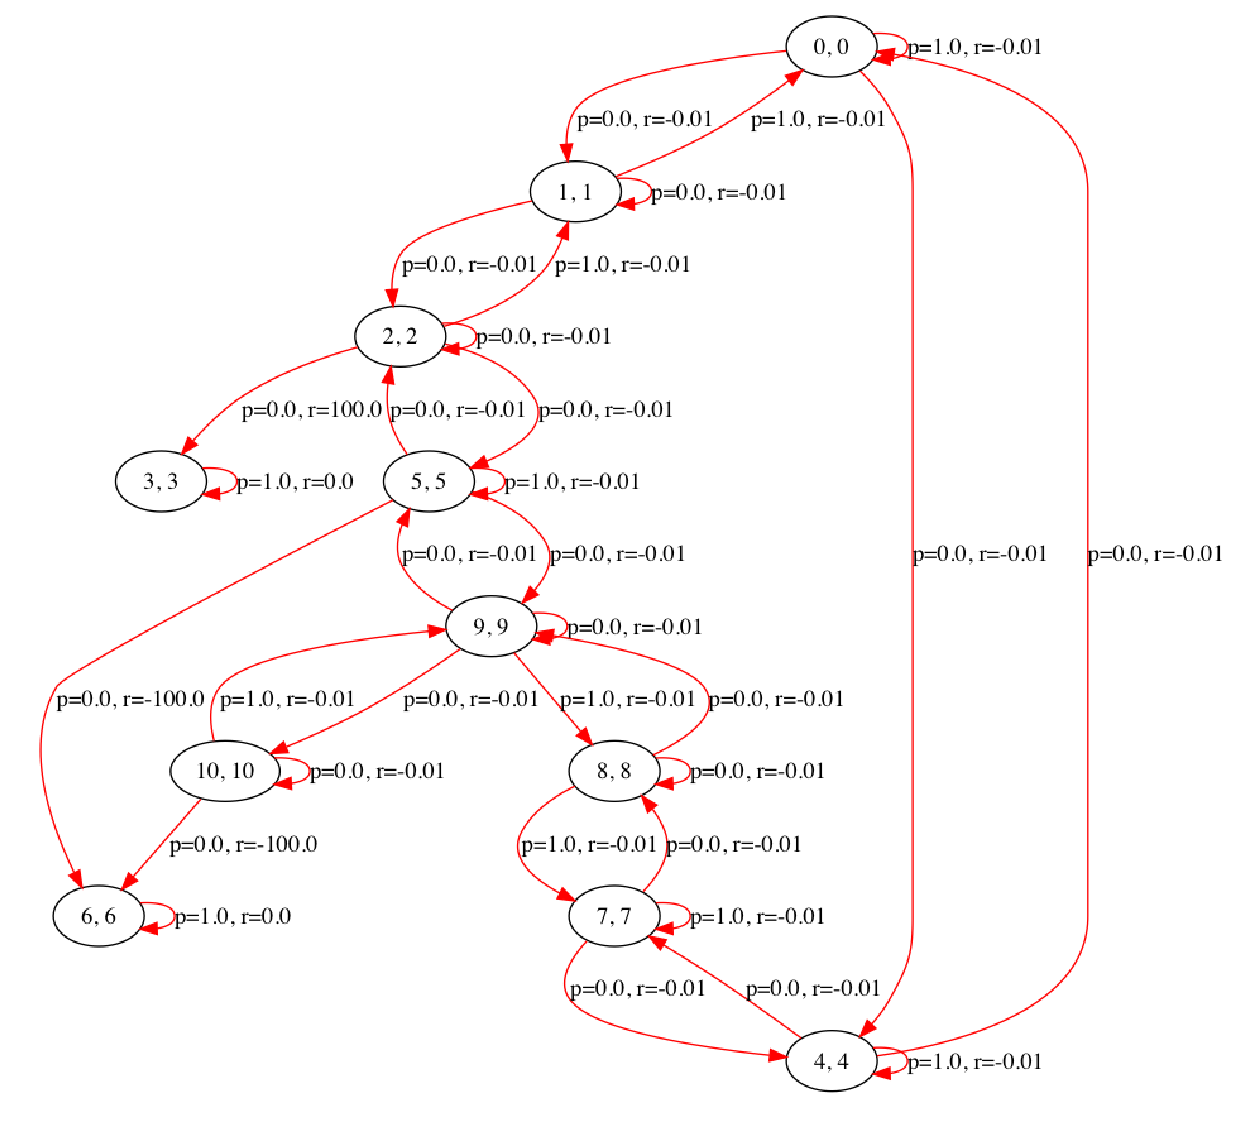

In [21]:
disp_mdp(mdp_descr, pi.V)